In [1]:
import os
import re

import nltk
import numpy as np
import polars as pl
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import mlflow

In [2]:
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Default url for MLFlow is "http://localhost:5000"
MLFLOW_TRACKING_URI = "http://localhost:5000"
DATASET_PATH = "../data/mlflow_data/toxic_comments.csv"
RANDOM_STATE = 42
N_JOBS = -1

In [4]:
os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
os.environ["AWS_SECRET_ACCESS_KEY"] = "password"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://127.0.0.1:9000"

In [5]:
experiments = mlflow.search_experiments()
print(experiments)

[<Experiment: artifact_location='file:///c:/dev/mlops_course/mlops_course/mlruns/0', creation_time=1715879720338, experiment_id='0', last_update_time=1715879720338, lifecycle_stage='active', name='Default', tags={}>]


In [6]:
df = pl.read_csv(DATASET_PATH, n_rows=50000)
pl.Config.set_fmt_str_lengths(100)
df.head(3)

,text,toxic
i64,str,i64
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't …",0
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…",0
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant …",0


In [7]:
# Compile templates for re expressions
stop_words = set(stopwords.words("english"))
url_pattern = re.compile(r"https?://\S+|www\.\S+|\[.*?\]|[^a-zA-Z\s]+|\w*\d\w*")
spec_chars_pattern = re.compile("[0-9 \-_]+")
non_alpha_pattern = re.compile("[^a-z A-Z]+")


def text_preprocessing(input_text: str) -> str:
    text = input_text.lower()
    text = url_pattern.sub("", text)
    text = spec_chars_pattern.sub(" ", text)
    text = non_alpha_pattern.sub(" ", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text.strip()


df = df.with_columns(pl.col("text").map_elements(text_preprocessing).str.split(" ").alias("corpus"))

df.head(5)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


,text,toxic,corpus
i64,str,i64,list[str]
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't …",0,"[""explanation"", ""edits"", … ""retired""]"
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…",0,"[""daww"", ""matches"", … ""utc""]"
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant …",0,"[""hey"", ""man"", … ""info""]"
3,""""" More I can't make any real suggestions on improvement - I wondered if the section statistics shoul…",0,"[""cant"", ""make"", … ""wikipediagoodarticlenominationstransport""]"
4,"""You, sir, are my hero. Any chance you remember what page that's on?""",0,"[""sir"", ""hero"", … ""thats""]"


In [8]:
def lemmatize(input_frame: pl.DataFrame) -> pl.DataFrame:
    lemmatizer = WordNetLemmatizer()

    return input_frame.with_columns(
        pl.col("corpus").map_elements(
            lambda input_list: [lemmatizer.lemmatize(token) for token in input_list]
        )
    )


df = lemmatize(df)
df.head(5)

C:\Users\Иван\AppData\Local\Temp\ipykernel_27136\3308074898.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  return input_frame.with_columns(


,text,toxic,corpus
i64,str,i64,list[str]
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't …",0,"[""explanation"", ""edits"", … ""retired""]"
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11…",0,"[""daww"", ""match"", … ""utc""]"
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant …",0,"[""hey"", ""man"", … ""info""]"
3,""""" More I can't make any real suggestions on improvement - I wondered if the section statistics shoul…",0,"[""cant"", ""make"", … ""wikipediagoodarticlenominationstransport""]"
4,"""You, sir, are my hero. Any chance you remember what page that's on?""",0,"[""sir"", ""hero"", … ""thats""]"


In [9]:
tf_idf_params = {"max_features": 10000, "analyzer": "word"}

tf_idf_vectorizer = TfidfVectorizer(**tf_idf_params)

train, test = train_test_split(
    df, test_size=0.25, random_state=RANDOM_STATE, stratify=df["toxic"], shuffle=True
)

tf_idf_vectorizer.fit(train["corpus"].to_pandas().astype(str))
train_features = tf_idf_vectorizer.transform(train["corpus"].to_pandas().astype(str))
test_features = tf_idf_vectorizer.transform(test["corpus"].to_pandas().astype(str))

In [10]:
def conf_matrix(y_true: np.ndarray, pred: np.ndarray) -> Figure:
    plt.ioff()
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, pred, ax=ax, colorbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    _ = ax.set_title("Confusion Matrix")
    plt.tight_layout()
    return fig

In [11]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
embeddings_experiment = mlflow.set_experiment("TF_IDF")

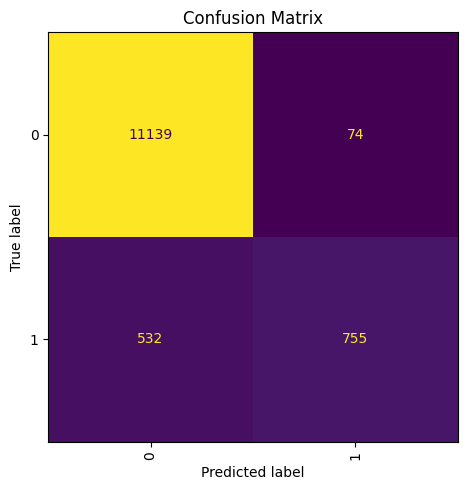

In [12]:
run_name = "logistic_regression"

with mlflow.start_run(run_name=run_name) as run:
    lr_model_params = {
        "multi_class": "multinomial",
        "solver": "saga",
        "random_state": RANDOM_STATE,
    }

    model_lr = LogisticRegression(**lr_model_params)
    model_lr.fit(train_features, train["toxic"])
    predicts = model_lr.predict(test_features)

    metrics = {
        "accuracy": accuracy_score(test["toxic"], predicts),
        "recall": recall_score(test["toxic"], predicts),
        "precision": precision_score(test["toxic"], predicts),
        "roc_auc_score": roc_auc_score(test["toxic"], predicts),
    }
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)

    mlflow.sklearn.log_model(sk_model=model_lr, artifact_path=f"mlflow/{run_name}/model")

    fig = conf_matrix(test["toxic"], predicts)
    mlflow.log_figure(figure=fig, artifact_file=f"{run_name}_confusion_matrix.png")

In [22]:
run_name = "catboost"

with mlflow.start_run(run_name=run_name) as run:
    catboost_model_params = {
        "random_state": 42,
        "learning_rate": 0.001,
        "auto_class_weights": "Balanced",
        "verbose": False,
        "n_estimators": 500,
    }

    model_catboost = CatBoostClassifier(**catboost_model_params)
    model_catboost.fit(train_features, np.array(train["toxic"]))
    predicts = model_catboost.predict(test_features)

    metrics = {
        "accuracy": accuracy_score(np.array(test["toxic"]), predicts),
        "recall": recall_score(np.array(test["toxic"]), predicts),
        "precision": precision_score(np.array(test["toxic"]), predicts),
        "roc_auc_score": roc_auc_score(np.array(test["toxic"]), predicts),
    }
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)

    mlflow.catboost.log_model(cb_model=model_catboost, artifact_path=f"mlflow/{run_name}/model")

    fig = conf_matrix(test["toxic"], predicts)
    mlflow.log_figure(figure=fig, artifact_file=f"{run_name}_confusion_matrix.png")

c:\dev\mlops_course\.venv\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\dev\mlops_course\.venv\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
